# COVID-19  classification # 
by Kartheek Raj Mulasa

**Importing Necessary Python libraries**

In [1]:
import glob
import numpy as np
from keras.preprocessing.image import load_img,img_to_array
import os
import matplotlib.pyplot as plt
import cv2 as cv2
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import  GlobalAveragePooling2D,BatchNormalization
from skimage.io import imshow
from sklearn.utils.multiclass import unique_labels

Using TensorFlow backend.


In [2]:
import keras; print(keras.__version__)


2.3.1


**Setting the Working Directory** 

In [3]:
os.getcwd()
os.chdir('C:\\Users\\mkart\\OneDrive\\Documents\\Deep Learning udemy\\COVID-19 Radiography Database\\whole data\\Train')

**Loading the Data**

**1.COVID**

In [4]:
img_size = (224,224)
#dir_name = ''
img_list = glob.glob('C:\\Users\\mkart\\OneDrive\\Documents\\Deep Learning udemy\\COVID-19 Radiography Database\\whole data\\Train\\COVID-19\\*')

list_covid = []
for img in img_list:
    temp_img = load_img(img,grayscale=True,target_size=(img_size))
    temp_img_array = img_to_array(temp_img) /255
    list_covid.append(temp_img_array)
list_covid = np.array(list_covid)
list_covid2 = list_covid.reshape(-1,50176)
df_covid=pd.DataFrame(list_covid2)
df_covid['label'] = np.full(df_covid.shape[0],2)




C:\Users\mkart\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [5]:
df_covid.shape

(559, 50177)

**2.NORMAL**

In [6]:
img_size = (224,224)
img_list2 = glob.glob('C:\\Users\\mkart\\OneDrive\\Documents\\Deep Learning udemy\\COVID-19 Radiography Database\\whole data\\Train\\NORMAL\\*')

list_normal = []
for img in img_list2[:]:
    temp_img = load_img(img,grayscale=True,target_size=(img_size))
    temp_img_array = img_to_array(temp_img) /255
    list_normal.append(temp_img_array)
list_normal = np.array(list_normal)
list_normal2 = list_normal.reshape(-1,50176)
df_normal=pd.DataFrame(list_normal2)
df_normal['label'] = np.full(df_normal.shape[0],0)

In [7]:
df_normal.shape

(1240, 50177)

**3.PNEUMONIA**

In [8]:
img_size = (224,224)
img_list3 = glob.glob('C:\\Users\\mkart\\OneDrive\\Documents\\Deep Learning udemy\\COVID-19 Radiography Database\\whole data\\Train\\Viral Pneumonia\\*')

list_others = []
for img in img_list3[:]:
    temp_img = load_img(img,grayscale=True,target_size=(img_size))
    temp_img_array = img_to_array(temp_img) /255
    list_others.append(temp_img_array)
list_others = np.array(list_others)
list_others2 = list_others.reshape(-1,50176)
df_others=pd.DataFrame(list_others2)
df_others['label'] = np.full(df_others.shape[0],1)

**Dispalying Imported Images**

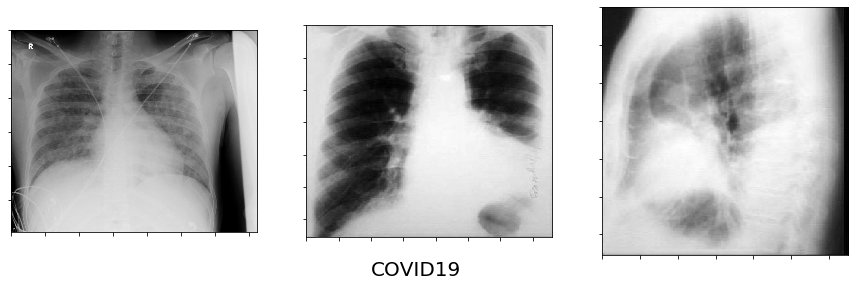

In [9]:
f = plt.figure(figsize=(15,7))
f.suptitle('COVID19',fontsize=20)
f.subplots_adjust(top=2.35)
for i in range(3):
    sp = f.add_subplot(1,3,i+1)
    img = cv2.imread(img_list[i])
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
    plt.imshow(img_gray)
    plt.gray()
plt.show()

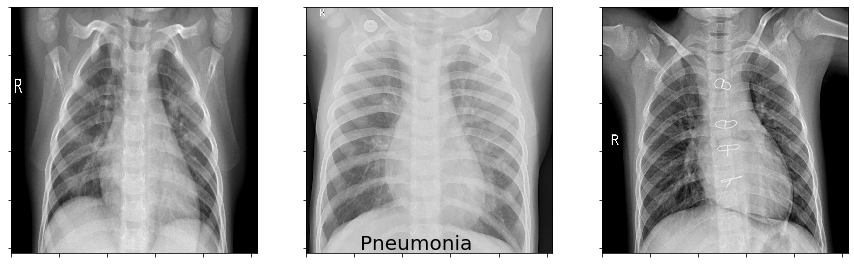

In [10]:
f = plt.figure(figsize=(15,7))
f.suptitle('Pneumonia',fontsize=20)
f.subplots_adjust(top=2.25)
for i in range(3):
    sp = f.add_subplot(1,3,i+1)
    img = cv2.imread(img_list3[i])
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
    plt.imshow(img_gray)
plt.gray()
plt.show()

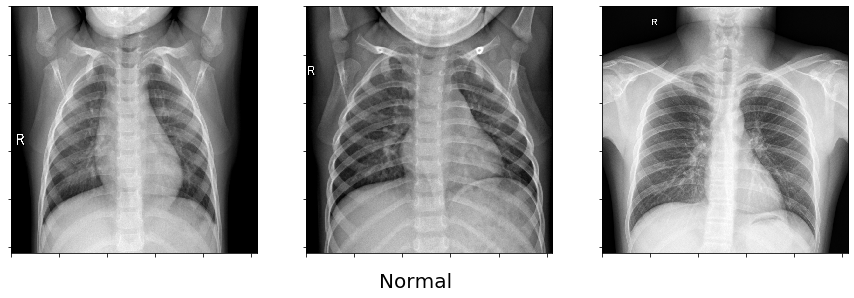

In [11]:
f = plt.figure(figsize=(15,7))
f.suptitle('Normal',fontsize=20)
f.subplots_adjust(top=2.4)
for i in range(3):
    sp = f.add_subplot(1,3,i+1)
    img = cv2.imread(img_list2[i])
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
    plt.imshow(img_gray)
plt.gray()
plt.show()

**Data Split -Train/Test**

In [12]:
Df = pd.concat([df_covid, df_normal , df_others], ignore_index=True)

In [13]:
print(Df.columns)

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
         50167,   50168,   50169,   50170,   50171,   50172,   50173,   50174,
         50175, 'label'],
      dtype='object', length=50177)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(Df.iloc[:,0:-1], Df.iloc[:,-1], test_size=0.20, random_state=0)

X_train = x_train.values.reshape(-1,224,224,1)
X_test = x_test.values.reshape(-1,224,224,1)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

### Applying PCA

In [15]:
from sklearn.decomposition import PCA
from time import time

n_components = 40
n_samples=411
h=224
w =224

print("Extracting the top %d eigenfaces from %d cases"
      % (n_components, x_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(x_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(x_train)
X_test_pca = pca.transform(x_test)
print("done in %0.3fs" % (time() - t0))


Extracting the top 40 eigenfaces from 2435 cases
done in 4.892s
Projecting the input data on the eigenfaces orthonormal basis
done in 1.578s


**PCA Components Expained Variance**

Text(0, 0.5, 'cumulative explained variance')

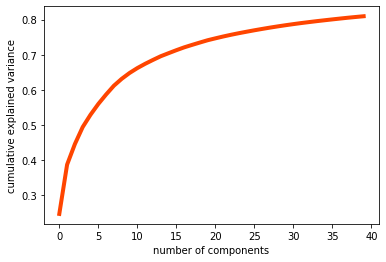

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='orangered', linewidth=4)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

<BarContainer object of 40 artists>

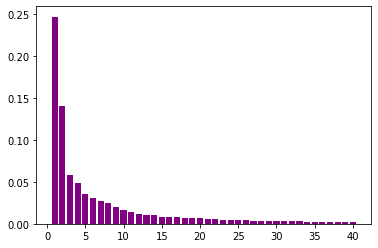

In [17]:
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_,color='purple')

**PCA Visualization**

All Components 

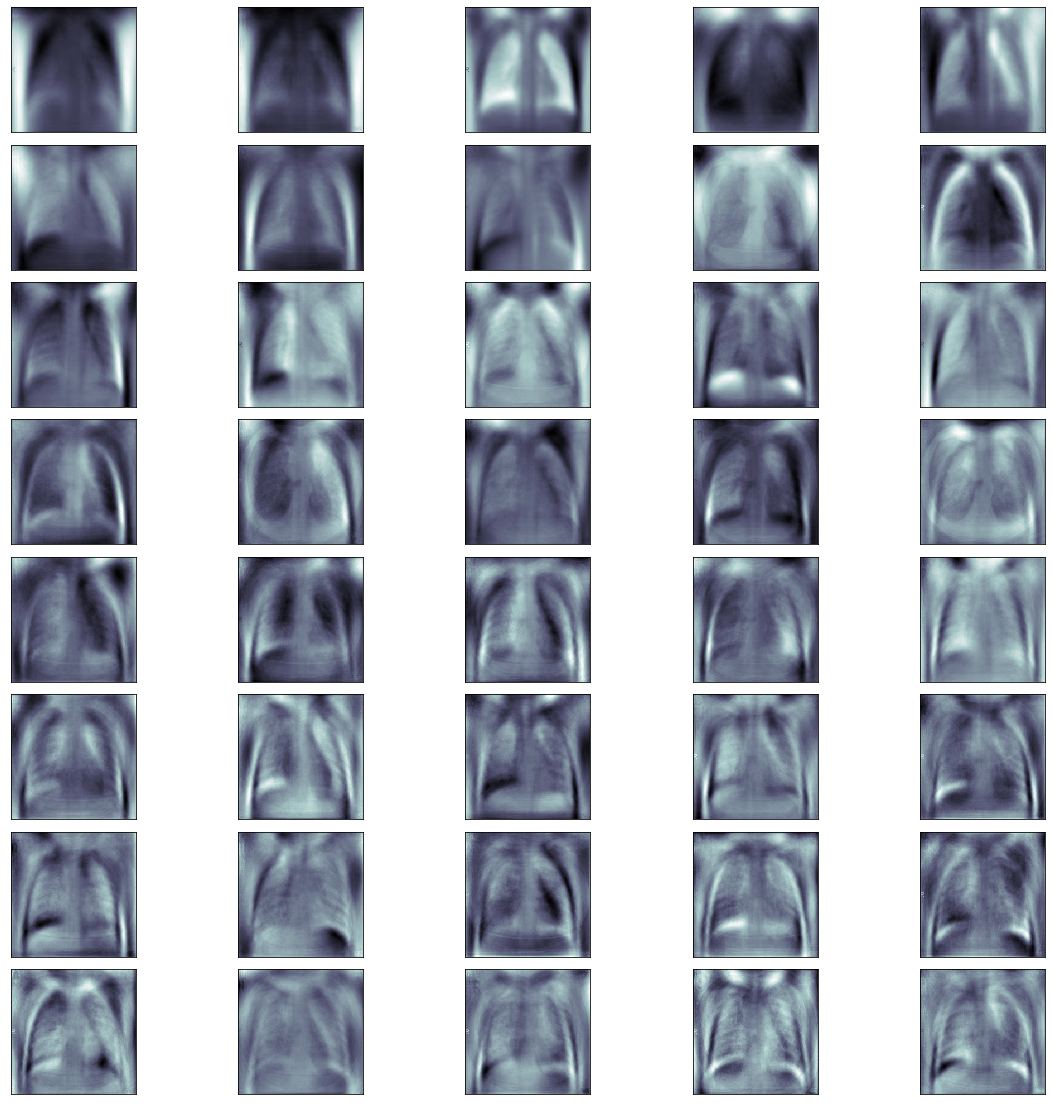

In [18]:
fig, axes = plt.subplots(8, 5, figsize=(20, 20),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(224, 224), cmap='bone')

First 5 PCA 

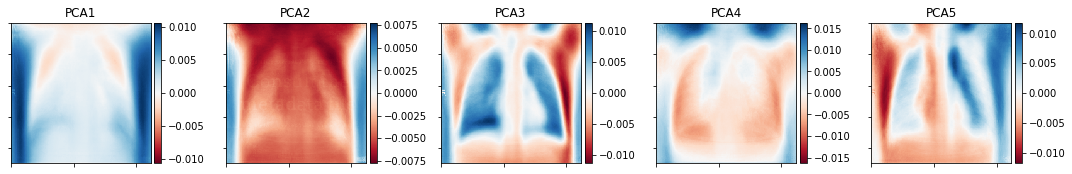

In [19]:
from skimage.io import imshow
loadeigen = eigenfaces[0]
f = plt.figure(figsize=(15,4))
f.subplots_adjust(top=1)
for i in range(5):
    sp = f.add_subplot(1,5,i+1)
    plt.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
    loadeigen = eigenfaces[i]
    imshow(loadeigen) 
    sp.title.set_text('PCA'+str(i+1))
plt.show()

PCA and the classes

In [20]:
pca_2D = PCA(n_components=2).fit_transform(x_train)
pca_2D

array([[-16.305983 ,  -7.089573 ],
       [-11.453943 ,   2.1625826],
       [ -3.606972 , -10.9638405],
       ...,
       [-10.325927 ,  18.111462 ],
       [ 39.61222  ,  -8.935476 ],
       [ 18.855707 ,  -4.1618166]], dtype=float32)

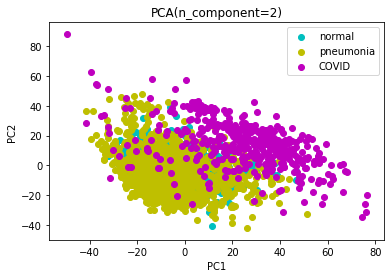

In [21]:
mycolors=["c","y","m"]
labelTups = ['normal','pneumonia','COVID']
label=y_train
for i,mycolor in enumerate(mycolors):
        plt.scatter(pca_2D[label == i, 0],
                    pca_2D[label == i, 1], color=mycolor)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend(labelTups, loc='upper right')
plt.title('PCA(n_component=2)')
plt.show()

## Logi Model

In [22]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_pca, y_train)

LogisticRegression()

In [23]:
y_pred = logreg.predict(X_test_pca)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_pca, y_test)))

Accuracy of logistic regression classifier on test set: 0.91


**Confusion Matrix**

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
target_names = ['normal','pneumonia', 'covid']
n_classes=3
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix)



              precision    recall  f1-score   support

      normal       0.93      0.91      0.92       258
   pneumonia       0.91      0.92      0.92       235
       covid       0.87      0.88      0.88       116

    accuracy                           0.91       609
   macro avg       0.90      0.91      0.90       609
weighted avg       0.91      0.91      0.91       609

[[236  13   9]
 [ 12 217   6]
 [  6   8 102]]


**ROC Curve**

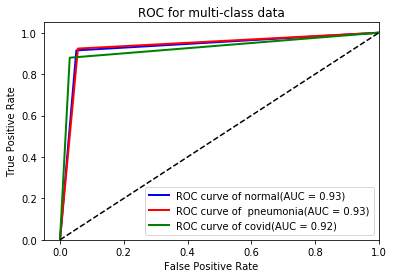

In [25]:
from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

PRED = to_categorical(y_pred)
y = Df['label'].values
# Binarize the output
y = label_binarize(y, classes=[0,1,2])
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
       fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], PRED[:,i])
       roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['blue', 'red', 'green']
cls = {0:'normal', 1:' pneumonia', 2:'covid'}
for i, color ,c in zip(range(n_classes), colors, cls.values()):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of '+c+ '(AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--',linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class data')
plt.legend(loc="lower right")
plt.show()

## SVM

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 10, 100,1e3, 5e3, 1e4],
              'gamma': [0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 26.947s
Best estimator found by grid search:
SVC(C=10, class_weight='balanced', gamma=0.01)


**Confusion Matrix**

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

target_names = ['normal','pneumonia', 'covid']
n_classes=3
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

done in 0.031s
              precision    recall  f1-score   support

      normal       0.97      0.94      0.95       258
   pneumonia       0.94      0.96      0.95       235
       covid       0.93      0.96      0.94       116

    accuracy                           0.95       609
   macro avg       0.95      0.95      0.95       609
weighted avg       0.95      0.95      0.95       609

[[243  10   5]
 [  7 225   3]
 [  1   4 111]]


**ROC Curve**

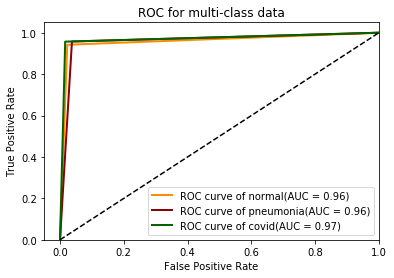

In [28]:
from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

PRED = to_categorical(y_pred)
y = Df['label'].values
# Binarize the output
y = label_binarize(y, classes=[0,1,2])
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
       fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], PRED[:,i])
       roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['darkorange', 'darkred', 'darkgreen']
cls = {0:'normal', 1:'pneumonia', 2:'covid'}
for i, color ,c in zip(range(n_classes), colors, cls.values()):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of '+c+ '(AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--',linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class data')
plt.legend(loc="lower right")
plt.show()

## Random Forest 

In [29]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(n_estimators=1000)
estimator.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [30]:
importances = estimator.feature_importances_
importances = importances.reshape(224,224)

**Confusion Matrix**

In [31]:
y_pred = estimator.predict(x_test)
print("done in %0.3fs" % (time() - t0))

target_names = ['normal','pneumonia', 'covid']
n_classes=3
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

done in 322.565s
              precision    recall  f1-score   support

      normal       0.95      0.90      0.93       258
   pneumonia       0.88      0.96      0.92       235
       covid       0.91      0.84      0.88       116

    accuracy                           0.91       609
   macro avg       0.91      0.90      0.91       609
weighted avg       0.92      0.91      0.91       609

[[232  20   6]
 [  5 226   4]
 [  6  12  98]]


**ROC Curve**

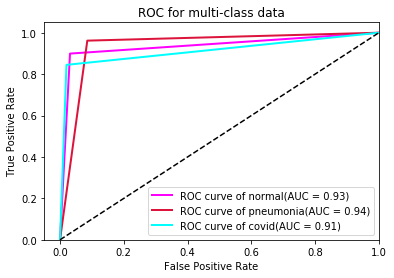

In [32]:
from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

PRED = to_categorical(y_pred)
y = Df['label'].values
# Binarize the output
y = label_binarize(y, classes=[0,1,2])
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
       fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], PRED[:,i])
       roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['magenta', 'crimson', 'cyan']
cls = {0:'normal', 1:'pneumonia', 2:'covid'}
for i, color ,c in zip(range(n_classes), colors, cls.values()):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of '+c+ '(AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--',linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class data')
plt.legend(loc="lower right")
plt.show()

## Convolutional Neural Network

### Data augmentation

**Training Dataset**

In [33]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   )
training_set = train_datagen.flow_from_directory('C:\\Users\\mkart\\OneDrive\\Documents\\Deep Learning udemy\\COVID-19 Radiography Database\\Dessertation\\Train',
                                                 target_size = (64, 64),
                                                 color_mode="grayscale",
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1469 images belonging to 3 classes.


In [34]:
print(training_set.class_indices)

{'COVID-19': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


**Validation  Dataset**

In [35]:
Validation_datagen =ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   )
Validation_set = Validation_datagen.flow_from_directory('C:\\Users\\mkart\\OneDrive\\Documents\\Deep Learning udemy\\COVID-19 Radiography Database\\Dessertation\\Train1',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            color_mode="grayscale",
                                            class_mode = 'categorical')

Found 1470 images belonging to 3 classes.


**Test Dataset**

In [36]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('C:\\Users\\mkart\\OneDrive\\Documents\\Deep Learning udemy\\COVID-19 Radiography Database\\whole data\\Test',
                                            target_size = (64, 64),
                                            color_mode="grayscale" )

Found 300 images belonging to 3 classes.


In [37]:
print(Validation_set.class_indices)

{'COVID-19': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


###  Building the CNN

**Initialising the CNN**

In [38]:
cnn = tf.keras.models.Sequential()

**Step 1 - Convolution**

In [39]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 1]))

Instructions for updating:
Colocations handled automatically by placer.


**Step 2 - Pooling**

In [40]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

Adding a second convolutional layer

In [41]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

**Step 3 - Flattening**

In [42]:
cnn.add(tf.keras.layers.Flatten())

**Step 4 - Full Connection**

In [43]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

**Step 5 - Output Layer**

In [44]:
cnn.add(tf.keras.layers.Dense(units=3, activation='softmax'))

Model summnary

In [45]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total para

### Training the CNN

**Compiling the CNN**

In [46]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

**Training the CNN on the Training set and evaluating it on the Test set**

In [47]:
history=cnn.fit(x = training_set, validation_data = Validation_set , epochs = 10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
46/46 [==============================] - 74s 2s/step - loss: 0.7317 - acc: 0.6787 - val_loss: 0.4471 - val_acc: 0.8354
Epoch 2/10
46/46 [==============================] - 72s 2s/step - loss: 0.4609 - acc: 0.8162 - val_loss: 0.4123 - val_acc: 0.8313
Epoch 3/10
46/46 [==============================] - 66s 1s/step - loss: 0.3830 - acc: 0.8421 - val_loss: 0.3262 - val_acc: 0.8782
Epoch 4/10
46/46 [==============================] - 68s 1s/step - loss: 0.3493 - acc: 0.8632 - val_loss: 0.3880 - val_acc: 0.8429
Epoch 5/10
46/46 [==============================] - 62s 1s/step - loss: 0.3569 - acc: 0.8666 - val_loss: 0.3123 - val_acc: 0.8769
Epoch 6/10
46/46 [==============================] - 64s 1s/step - loss: 0.3490 - acc: 0.8686 - val_loss: 0.3171 - val_acc: 0.8782
Epoch 7/10
46/46 [==============================] - 72s 2s/step - loss: 0.3371 - acc: 0.8734 - val_loss: 0.3514 - val_acc: 0.8463
Epoch 8/10
46/46 [========================

### Model Performance 

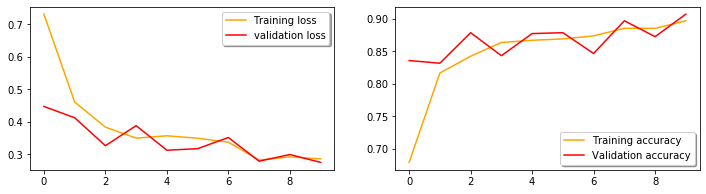

In [48]:
plt.style.use('seaborn-bright')
fig, ax = plt.subplots(1,2, figsize=(12, 3))
ax[0].plot(history.history['loss'], color='orange', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['acc'], color='orange', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Confusion Matrix**

In [49]:
pred = cnn.predict_classes(test_set)
cnnp=cnn.predict_proba(test_set)
cm = metrics.confusion_matrix(test_set.classes,pred)
from sklearn.metrics import classification_report
print(classification_report(pred,test_set.classes))
print(' covid19 = 0 , normal = 1, pneumonia = 2')
print(cm)

              precision    recall  f1-score   support

           0       0.36      0.40      0.38        91
           1       0.40      0.33      0.36       120
           2       0.29      0.33      0.31        89

    accuracy                           0.35       300
   macro avg       0.35      0.35      0.35       300
weighted avg       0.36      0.35      0.35       300

 covid19 = 0 , normal = 1, pneumonia = 2
[[36 36 28]
 [28 40 32]
 [27 44 29]]


**ROC Curve**

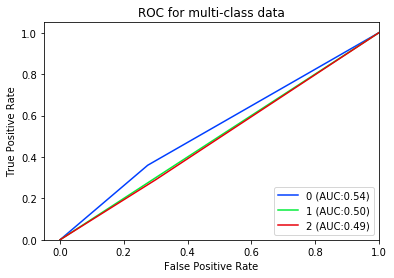

In [50]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
# set plot figure size
fig, c_ax = plt.subplots()

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    #all_labels= {0:'normal', 1:'pneumonia', 2:'covid'}
    all_labels= {'normal', 'pneumonia', 'covid'}

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        colors = ['magenta', 'crimson', 'cyan']
    
    return roc_auc_score(y_test, y_pred, average=average)




multiclass_roc_auc_score(test_set.classes, pred)

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class data')
plt.legend(loc="lower right")
plt.show()


## Transfer Learning with Imagenet

In [51]:
train_datagen = ImageDataGenerator(
horizontal_flip=True,
vertical_flip=True,
rotation_range=90,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=.1,
rescale=1/255,
fill_mode='nearest',
shear_range=0.1,
brightness_range=[0.5, 1.5],
validation_split=0.3)

training_set_tl = train_datagen.flow_from_directory('C:\\Users\\mkart\\OneDrive\\Documents\\Deep Learning udemy\\COVID-19 Radiography Database\\Dessertation\\Train',
                                                 target_size = (224, 224),
                                                 batch_size = 48,
                                                 class_mode = 'categorical')

Found 1469 images belonging to 3 classes.


In [52]:
Validation_datagen =ImageDataGenerator(
horizontal_flip=True,
vertical_flip=True,
rotation_range=90,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=.1,
rescale=1/255,
fill_mode='nearest',
shear_range=0.1,
brightness_range=[0.5, 1.5],
validation_split=0.3)

Validation_set_tl = Validation_datagen.flow_from_directory('C:\\Users\\mkart\\OneDrive\\Documents\\Deep Learning udemy\\COVID-19 Radiography Database\\Dessertation\\Train1',
                                            target_size = (224, 224),
                                            batch_size = 48,
                                            class_mode = 'categorical')

Found 1470 images belonging to 3 classes.


In [53]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set_tl = test_datagen.flow_from_directory('C:\\Users\\mkart\\OneDrive\\Documents\\Deep Learning udemy\\COVID-19 Radiography Database\\whole data\\Test',
                                            target_size = (224, 224)
)

Found 300 images belonging to 3 classes.


In [54]:
#Imported libraries and modules
import efficientnet.keras as efn
from sklearn.metrics import classification_report,accuracy_score,f1_score,confusion_matrix
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D
from keras.layers import  GlobalAveragePooling2D,BatchNormalization

In [55]:
import efficientnet.keras as efn
from keras.models import Model

In [56]:
img_shape=224
import efficientnet.keras as efn
#using here EfficientNet series BO
baseModel =efn.EfficientNetB0(weights ='noisy-student', include_top=False, input_shape = (img_shape,img_shape,3))
baseModel.summary()
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
for layer in baseModel.layers:
    layer.trainable = False
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [57]:
results = model.fit(training_set_tl,epochs=10,steps_per_epoch=5,validation_data=Validation_set_tl,validation_steps=15)

Epoch 1/10
5/5 [==============================] - 340s 68s/step - loss: 1.1115 - accuracy: 0.3801 - val_loss: 1.1055 - val_accuracy: 0.3347
Epoch 2/10
5/5 [==============================] - 294s 59s/step - loss: 0.9697 - accuracy: 0.5375 - val_loss: 1.1288 - val_accuracy: 0.3028
Epoch 3/10
5/5 [==============================] - 304s 61s/step - loss: 0.9270 - accuracy: 0.5375 - val_loss: 1.0700 - val_accuracy: 0.4188
Epoch 4/10
5/5 [==============================] - 315s 63s/step - loss: 0.8821 - accuracy: 0.6125 - val_loss: 1.0326 - val_accuracy: 0.4667
Epoch 5/10
5/5 [==============================] - 297s 59s/step - loss: 0.7768 - accuracy: 0.7042 - val_loss: 1.0606 - val_accuracy: 0.4601
Epoch 6/10
5/5 [==============================] - 286s 57s/step - loss: 0.7477 - accuracy: 0.7000 - val_loss: 0.9793 - val_accuracy: 0.5306
Epoch 7/10
5/5 [==============================] - 292s 58s/step - loss: 0.6435 - accuracy: 0.7421 - val_loss: 0.8627 - val_accuracy: 0.5627
Epoch 8/10
5/5 [====

In [59]:
from sklearn.metrics import classification_report
print(classification_report(pred_tl,test_set_tl.classes))
print(' covid19 = 0 , normal = 1, pneumonia = 2')

              precision    recall  f1-score   support

           0       0.42      0.34      0.38       124
           1       0.38      0.32      0.35       118
           2       0.19      0.33      0.24        58

    accuracy                           0.33       300
   macro avg       0.33      0.33      0.32       300
weighted avg       0.36      0.33      0.34       300

 covid19 = 0 , normal = 1, pneumonia = 2


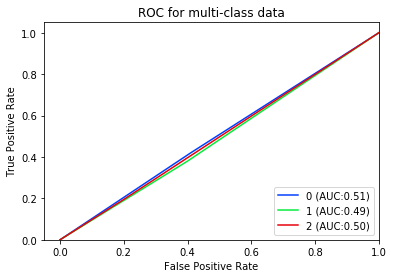

In [60]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
# set plot figure size
fig, c_ax = plt.subplots()

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    all_labels= {0:'normal', 1:'pneumonia', 2:'covid'}

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        colors = ['magenta', 'crimson', 'cyan']
    
    return roc_auc_score(y_test, y_pred, average=average)




multiclass_roc_auc_score(test_set_tl.classes, pred_tl)

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class data')
plt.legend(loc="lower right")
plt.show()